In [62]:
# BASE IMPORT
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import json
import shutil

In [63]:
import tensorflow as tf
from keras import layers
from keras import losses
from keras.models import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from sklearn.metrics import accuracy_score
tf.config.run_functions_eagerly(True)

In [64]:
from funcs import local_path
from funcs import dataprocesser

In [65]:
ABSOLUTE_DATASET_DIR = local_path.from_cd_dir('../../dataset_1/')
ABSOLUTE_CACHE_DIR = local_path.from_cd_dir('../cache/dataset/')
ABSOLUTE_WEIGHTS_DIR = local_path.from_cd_dir('../weights/')

In [67]:
IMAGE_SIZE = 256 # Càng lớn, dộ chính xác càng cao. Chạy càng chậm. QUAN TRỌNG: Phải là một số chia hết cho 8
EPOCHS = 2 # 
BATCH_SIZE = 8 # QUAN TRỌNG: Phải là một số chia hết cho 8
WEIGHT_NAME = 'test'
PACKAGE_SIZE = 16 # Ram nhiều thì PACKAGE_SIZE lớn. Quan trọng phải là một số chia hết cho 8

In [68]:
ABSOLUTE_SAVE_WEIGHT_DIR = os.path.join(ABSOLUTE_WEIGHTS_DIR, WEIGHT_NAME)
ABSOLUTE_SAVE_LAST_WEIGHT_DIR = os.path.join(ABSOLUTE_SAVE_WEIGHT_DIR, WEIGHT_NAME)

In [69]:
local_path.make_sure_dir_exists(ABSOLUTE_SAVE_WEIGHT_DIR)
local_path.make_sure_dir_exists(ABSOLUTE_CACHE_DIR)
local_path.make_sure_dir_exists(ABSOLUTE_SAVE_LAST_WEIGHT_DIR)

In [70]:
# Hàm này có tác dụng tiền sử lý hình ảnh
def pre_processing_image(img:np.ndarray):
    img_result = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Chuyển đổi hệ số màu BGR => RGB
    img_result = cv2.resize(img, dsize=(IMAGE_SIZE, IMAGE_SIZE)) # Resize image sao cho bàng với input shape
    img_result = img_result/255 # [0->255] => [0->1]
    return img_result

In [71]:
def make_model(number_objects:int):
    # input_shape = (IMAGE_SIZE, IMAGE_SIZE) // Trong đó IMAGE_SIZE được khai báo ở bên trên
    # IMAGE_SIZE càng lớn, độ chính sác càng cao.  Tốc độ càng chậm
    # Tiếp theo là các layer của resnet
    # Làm phảng trước khi đi diến lớp đầu ra
    # Trong trường hợp này lớp output có 5 noron tương ứng với 5 nhãn. Gồm 4 bạn và 1 nhãn undefined ! 

    base_model = InceptionResNetV2(
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        weights='imagenet',
        include_top=False
    )
    
    for layer in base_model.layers:
        layer.trainable=False

    out_model=layers.Flatten()(base_model.output)
    out_model=layers.Dense(units=number_objects, activation='softmax')(out_model)
    model = Model(base_model.input, out_model)

    model.compile(
        optimizer='adam',
        loss=losses.categorical_crossentropy,
        metrics=['accuracy']
    )
    
    return model

In [72]:
def predict_to_index(y:np.ndarray):
    return [np.argmax(item) for item in y]

In [ ]:
# ============================================================================

In [73]:
data_info = {}
with open(local_path.realpath(ABSOLUTE_DATASET_DIR, 'info.json'), 'r', encoding='utf-8') as f:
    data_info = json.loads(f.read())

In [74]:
data_info

{'labelnames': {'0_undefined': 'Không xác định',
  '1_tran-minh-chien': 'Trần Minh Chiến',
  '2_le-tran-anh-tuan': 'Lê Trần Anh Tuấn'}}

In [75]:
# Bạn nên sử dụng hàm này để load các hình ảnh lên vì nếu bạn tự viết code để load ảnh thì
# rất dễ xảy ra lỗi tràn bộ nhớ ram do số lượng ảnh đưa vào để train là quá lớn

data, labels_names = dataprocesser.load_dataset(
    absolute_data_dir=local_path.realpath(ABSOLUTE_DATASET_DIR, 'data'),
    prev_processing_function=pre_processing_image,
    package_size=PACKAGE_SIZE,
    absolute_cache_dir=ABSOLUTE_CACHE_DIR
)


[i] Đang liệt kê danh sách các files

    + Label: "0_undefined" : "C:\Resources\workspaces\customer\levanducanh\dataset_1\data\0_undefined"
    + Label: "1_tran-minh-chien" : "C:\Resources\workspaces\customer\levanducanh\dataset_1\data\1_tran-minh-chien"
    + Label: "2_le-tran-anh-tuan" : "C:\Resources\workspaces\customer\levanducanh\dataset_1\data\2_le-tran-anh-tuan"
Random....
[['1_tran-minh-chien', 'C:\\Resources\\workspaces\\customer\\levanducanh\\dataset_1\\data\\1_tran-minh-chien\\tran-minh-chien_0000000012.jpg'], ['2_le-tran-anh-tuan', 'C:\\Resources\\workspaces\\customer\\levanducanh\\dataset_1\\data\\2_le-tran-anh-tuan\\0000000014.jpg'], ['2_le-tran-anh-tuan', 'C:\\Resources\\workspaces\\customer\\levanducanh\\dataset_1\\data\\2_le-tran-anh-tuan\\0000000024.jpg'], ['2_le-tran-anh-tuan', 'C:\\Resources\\workspaces\\customer\\levanducanh\\dataset_1\\data\\2_le-tran-anh-tuan\\0000000007.jpg'], ['1_tran-minh-chien', 'C:\\Resources\\workspaces\\customer\\levanducanh\\dataset_1\\

In [76]:
labelnames_processed = [data_info['labelnames'][k] for k in labels_names]
print(labelnames_processed)

['Không xác định', 'Trần Minh Chiến', 'Lê Trần Anh Tuấn']


In [77]:
data_train = data[0:-2]
data_val = data[-2]
data_test = data[-1]

In [53]:
# Có thể chạy hoặc không
# Lưu lại danh sách các ID trong data vừa nạp

with open(os.path.join(ABSOLUTE_CACHE_DIR, '__index.txt'), 'w', encoding='utf-8') as f:
    f.write('\n'.join(data))
    f.close()


 [0. 0. 1.] Lê Trần Anh Tuấn


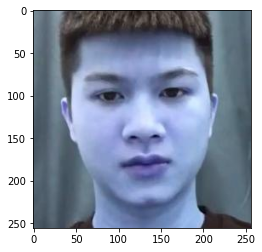


 [1. 0. 0.] Không xác định


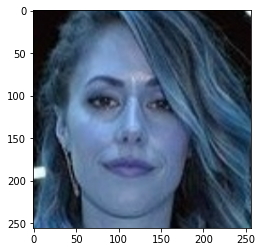


 [0. 0. 1.] Lê Trần Anh Tuấn


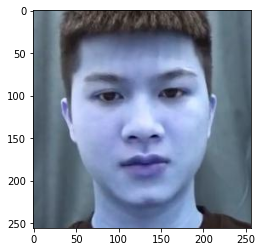


 [1. 0. 0.] Không xác định


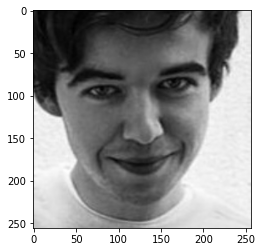


 [1. 0. 0.] Không xác định


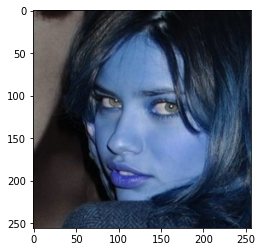


 [0. 1. 0.] Trần Minh Chiến


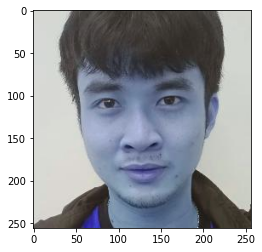


 [0. 1. 0.] Trần Minh Chiến


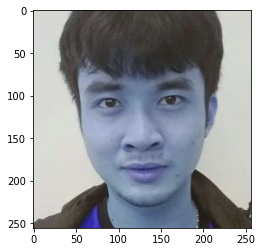


 [1. 0. 0.] Không xác định


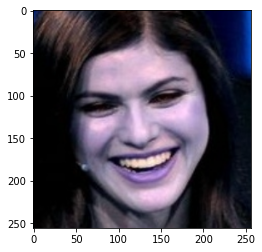


 [0. 0. 1.] Lê Trần Anh Tuấn


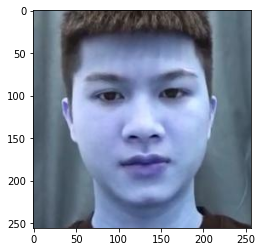


 [1. 0. 0.] Không xác định


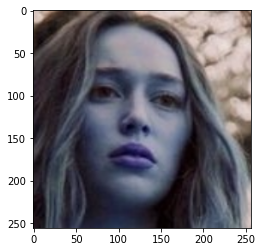

In [55]:
def display_dataset(id:str):
    x, y = dataprocesser.load_from_package(id, absolute_cache_dir=ABSOLUTE_CACHE_DIR)
    for i in range(10):
        print('\n', y[i], labelnames_processed[np.argmax(y[i])])
        plt.figure()
        plt.imshow(x[i])
        plt.show()

display_dataset(data_train[0])

In [78]:
model = make_model(len(labels_names))

In [79]:
x_val, y_val = dataprocesser.load_from_package(data_val, absolute_cache_dir=ABSOLUTE_CACHE_DIR)

In [80]:
# Train
# Train thành nhiều gói nhỏ để tránh tràn bộ nhớ ram và để tránh lúc xảy ra lỗi thì công train bay màu hết !
# Bạn có thể dừng việc train bất cứ lúc nào bạn cảm thất thích hợp và tiếp tục chạy hàm complete để hoàn thiện việc train
for i, package_id in enumerate(data_train):
    print(f'\n Package[{i}]: {package_id}')
    path_to_save = local_path.realpath(ABSOLUTE_SAVE_WEIGHT_DIR, 'package_' + str(i).rjust(4, '0'))
    local_path.make_sure_dir_exists(path_to_save)

    x_train, y_train = dataprocesser.load_from_package(package_id, absolute_cache_dir=ABSOLUTE_CACHE_DIR)
    
    history = model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_val, y_val),
        batch_size=BATCH_SIZE,
        validation_batch_size=BATCH_SIZE,
        epochs=EPOCHS
    )

    weight_save_path = local_path.realpath(path_to_save, 'lass.h5')
    print(f'Saved weight at: "{weight_save_path}"')
    model.save(weight_save_path, save_format='h5')

    #========
    try:
        with open(local_path.realpath(path_to_save, 'history.json'), 'w', encoding='utf-8') as f:
            f.write(json.dumps(dict(history)))
    except:
        print('Save history failed!')

    #========
    try:
        with open(local_path.realpath(path_to_save, 'label.json'), 'w', encoding='utf-8') as f:
            f.write(json.dumps({
                'labels': labelnames_processed
            }))
    except:
        print('Save label failed!')




 Package[0]: 18c961d3-01d7-48dc-9f97-3db017b29fdf
Epoch 1/2


c:\lapis\program_files\python39\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 [==============================] - 25s 14s/step - loss: 3.5012 - accuracy: 0.4375 - val_loss: 3.8658 - val_accuracy: 0.6875
Epoch 2/2
2/2 [==============================] - 21s 13s/step - loss: 0.7643 - accuracy: 0.9375 - val_loss: 2.3434 - val_accuracy: 0.8750
Saved weight at: "C:\Resources\workspaces\customer\levanducanh\train\weights\test\package_0000\lass.h5"
Save history failed!

 Package[1]: 098a4b97-32b4-4c85-86dc-c9f6a97a26fc
Epoch 1/2
2/2 [==============================] - 24s 14s/step - loss: 0.2679 - accuracy: 0.9375 - val_loss: 1.5915 - val_accuracy: 0.9375
Epoch 2/2
2/2 [==============================] - 21s 13s/step - loss: 2.2649e-06 - accuracy: 1.0000 - val_loss: 1.4486 - val_accuracy: 0.9375
Saved weight at: "C:\Resources\workspaces\customer\levanducanh\train\weights\test\package_0001\lass.h5"
Save history failed!

 Package[2]: 26ffdf04-ac7a-4c18-a0d4-324435e60bb3
Epoch 1/2
2/2 [==============================] - 24s 14s/step - loss: 6.4528e-05 - accuracy: 1.0000 - 

In [82]:
def complete():
    packages_saved = os.listdir(ABSOLUTE_SAVE_WEIGHT_DIR)
    packages_saved.sort(reverse=True)
    packages_saved = list(filter(lambda x: x.startswith('package'), packages_saved))
    
    for package_name in packages_saved:
        weight_path = local_path.realpath(ABSOLUTE_SAVE_WEIGHT_DIR, package_name, 'last.h5')
        if os.path.exists(weight_path):
            print(weight_path)
            shutil.copy(weight_path, os.path.join(ABSOLUTE_SAVE_LAST_WEIGHT_DIR, WEIGHT_NAME + '.h5'))

            with open(os.path.join(ABSOLUTE_SAVE_LAST_WEIGHT_DIR, WEIGHT_NAME + '.json'), 'w', encoding='utf-8') as f:
                f.write(json.dumps({
                    'labels': labelnames_processed
                }, indent=4))
                f.close()

            return
complete()



accuracy=1.0


true 0_undefined
predict 0_undefined


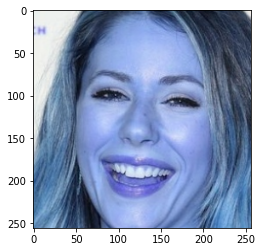



-------------


true 1_tran-minh-chien
predict 1_tran-minh-chien


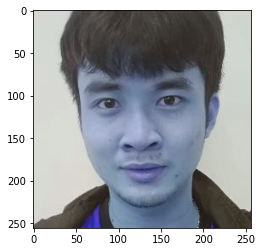



-------------


true 2_le-tran-anh-tuan
predict 2_le-tran-anh-tuan


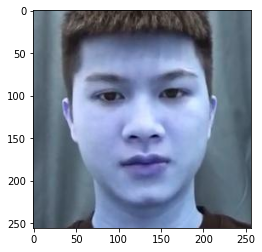



-------------


true 1_tran-minh-chien
predict 1_tran-minh-chien


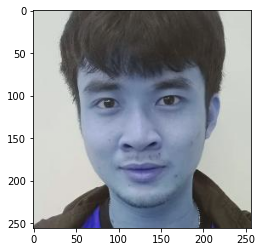



-------------


true 2_le-tran-anh-tuan
predict 2_le-tran-anh-tuan


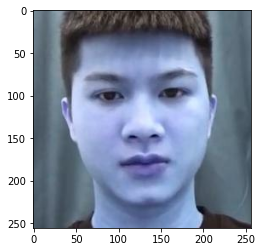



-------------


true 2_le-tran-anh-tuan
predict 2_le-tran-anh-tuan




-------------


true 2_le-tran-anh-tuan
predict 2_le-tran-anh-tuan


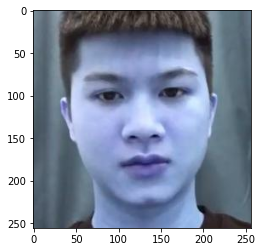



-------------


true 2_le-tran-anh-tuan
predict 2_le-tran-anh-tuan




-------------


true 1_tran-minh-chien
predict 1_tran-minh-chien


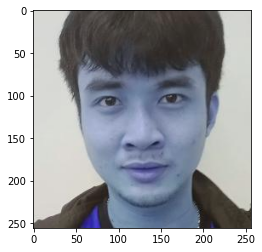



-------------


true 2_le-tran-anh-tuan
predict 2_le-tran-anh-tuan


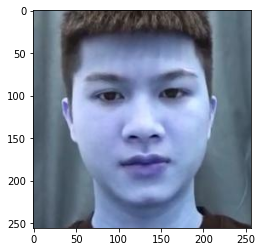



-------------




In [83]:
def test():
    x_test, y_test = dataprocesser.load_from_package(data_test, absolute_cache_dir=ABSOLUTE_CACHE_DIR)
    y_pred = predict_to_index(model.predict(x_test))
    y_true = predict_to_index(y_test)

    accuracy = accuracy_score(y_true, y_pred)
    print(f'\n\n{accuracy=}\n\n')
    
    for i in range(0, 10):
        print('true', labels_names[y_true[i]])
        print('predict', labels_names[y_pred[i]])

        plt.figure()
        plt.imshow(x_test[i])
        plt.show()

        print('\n\n-------------\n\n')

test()